# Unidad 3 - 04 Embebimiento lineal local


Esta notebook está basada en https://github.com/drewwilimitis/Manifold-Learning y en el libro Open Problems in Spectral Dimensionality Reduction (Strange y Zwiggelaar).

El embebimiento lineal local (locally linear embedding - LLE) se basa en la idea de que entornos suficientemente chicos representan cartas a lo largo de la variedad, que serán aproximadamente lineales. *Entrenando* localmente a lo largo de la variedad y *aprendiendo* las relaciones definidas entre la estructura intrínseca de los datos, LLE puede aprender globalmente en la variedad.

La clave es que definimos los puntos de datos en términos de sus relaciones locales lineales. Un punto de dato $x_i$ será una combinación lineal de sus vecinos locales, y buscamos un embedding a una dimensión menor que preserve esas relaciones lineales locales.

A diferencia de Isomap y otros que construyen una matriz de distancia densa para modelar las distancias geodésicas globales, LLE construye una matriz sparse basada en la estructura lineal local de la variedad, construyendo un embedding a un espacio de dimensión baja a partir de los autovalores más pequeños. Es una técnica local para reducir la dimensión.

 * En primer lugar LLE describe cada punto de dato de entrada en términos de los pesos que se necesitan para reconstruirlo a partir de sus vecinos más cercanos. Los pesos se construyen a partir de las distancias euclídeas, pues localmente, los datos, se entienden lineales.  $$e(W)=\sum_i ||x_i-\sum_j W_{ij} x_j||^2,$$ que se minimiza con las restricciones: $W_{ij}=0$ si $x_j$ no está en el k-vecindario de $x_i$ y $\sum_j W_{ij} = 1$ para todo $i$. Obtenemos así una matriz sparse $W$.

 * En segundo lugar se reconstruye el dato en el espacio de dimensión baja a partir de la matriz $W$, minimizando la función de costo del embedding: $$\Phi(Y)=\sum_i ||y_i-\sum_j W_{ij} y_j||^2$$,con la restricción de que las salidas estén centradas: $\sum_i y_i =0$ y tengan covariancia 1 (esto se pide para asegurar que la solución no es degenerada y que se pueda minimizar la ecuación a partir del cálculo de los $d+1$ últimos autovectores de la matriz $F=(I-W)^t(I-W)$, descartando el último.


Observemos que como es un método local, no se obtiene la forma de la variedad original.

La novedad de LLE es que la geometría local se modela sobre un único sistema coordenado.


![lle](https://user-images.githubusercontent.com/16658498/56095416-5c6ef800-5ea2-11e9-8ce0-5da013aee4e8.gif)<br>

**Fuente**: S. T. Roweis and L. K. Saul. *Nonlinear dimensionality reduction by locally linear
embedding*

### Descripción del algoritmo:

**Input:** Vectores de datos $\mathbf{x_1}, ..., \mathbf{x_n} \in \mathbb{R^d}$ con parámetros $k$ (nearest neighbors, cantidad de vecinos cercanos) y $m$ (dimensión sobre la cual embeberemos).

**Output:** Vectores de dimensión baja embebidos localmente $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$ con $m < d$.

**Pasos**:

1. Hallar $k$ vecinos más cercanos para cada $x_i$.
2. Hallar $W$ matriz de pesos que reconstruyan cada $x_i$ como combinación lineal de sus vecinos.
3. Hallar las coordenadas para el embebimiento en el espacio de menor dimensión $y_i \in \mathbb{R}^m$ de modo que se preserven las relaciones lineales.

### Paso 1: Hallar $k$ vecinos cercanos (nearest neighbours)

El parámetro $k$ debe ser previamente definido para especificar la cantidad de vecinos cercanos que usaremos para modelar linealmente cada $x_i$.

No hay una forma para saber a priori el valor óptimo de $k$ antes de aplicar el algoritmo, y distintos valores de $k$ pueden afectar drásticamente el desempeño del LLE.

Veamos un ejemplo de cómo puede variar con distintos valores de $k$, usando LLE de la librería
`sklearn.manifold` de scikitlearn.

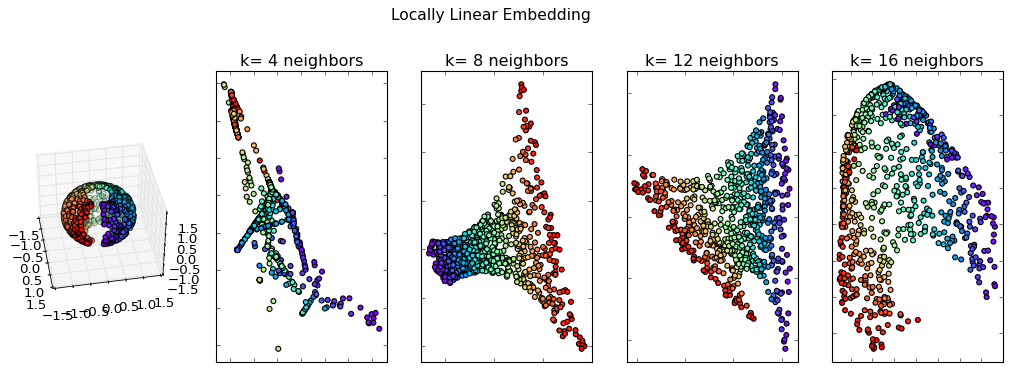

In [1]:
# modificado de: https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# mostrar múltiples salidas en una sola celda
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

n_samples = 1000

# crear nuestra esfera
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# quitar los polos de la esfera
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# graficar el dataset
fig = plt.figure(figsize=(16, 10))
plt.suptitle("Locally Linear Embedding", fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# mandarle el LLE
neighbors = np.arange(4, 20, 4)

for i, neighbor in enumerate(neighbors):
    trans_data = (manifold.LocallyLinearEmbedding(n_neighbors=neighbor, n_components=2, method="standard", random_state=42).fit_transform(sphere_data).T)
    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow);
    ax.xaxis.set_major_formatter(NullFormatter());
    ax.yaxis.set_major_formatter(NullFormatter());
    plt.title('k= ' +str(neighbor) + ' neighbors')
    plt.axis('tight');
plt.show();

Pareciera que el valor óptimo para k es entre 8 y 12.

Cuando usamos un valor bajo para k, las combinaciones lineales no tienen suficientes puntos vecinos para trasladar con precisión la estructura de la variedad.

Para valores muy grandes de k, los entornos se empiezan a agrandar e incluyen demasiado de la estructura global de la variedad, de modo que el embedding se hace "más curvo".

## Paso 2: Combinaciones lineales y pesos óptimos

Luego de hallar los vecinos más cercanos, definimos los puntos dato $x_i$ en términos de las relaciones lineales locales que hay en el entorno. Para cada $x_i$ de dimensión $d$, lo reconstruímos usando una combinación lineal de sus k vecinos más cercanos. Observemos que esta combinación también es en dimensión $d$.

Para cada punto $x_i$ definimos una combinación lineal con el la matriz de coeficientes de pesos
 $W \in \mathbb{R}^{k \times n}$ que determina la contribución de cada uno de los vecinos cercanos $x_j$. Para la matriz de pesos $W$ tenemos:

$$\mathbf{W} = \begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1k} \\
w_{21} & w_{22} & \cdots & w_{2k} \\
\vdots & \vdots & \vdots & \vdots \\
w_{n1} & w_{n2} & \cdots & w_{nk}
\end{bmatrix}.$$

W es una matriz $n\times k$.

Para un $x_i$ tenemos la combinación lineal
$$\sum_{j=1}^{k} w_{ij} x_j = w_{i1} x_{1} + \cdots + w_{ik} x_{k}$$.

Como queremos reconstruír con precisión $x_i$ como combinación lineal, tenemos que el error de reconstrucción total está definido por la siguiente función de costo:
$$\mathcal{E}(W) = \sum_{i} ||x_i - \sum_{j} w_{ij} x_j||^2.$$

Esta función representa la distancia euclídea residual entre los $x_i$ originales y su reconstrucción con los k vecinos más cercanos.

Como los $x_i$ son datos que ya tenemos, la función de costo es una función de los pesos, luego minimizamos la función encontrando los pesos óptimos para obtener el menor error de reconstrucción.

IMPORTANTE:

Por la forma en la que hemos definido la función de costo, los pesos óptimos son invariantes a rotaciones, escalamientos y traslaciones, de modo que reflejan las propiedades geométricas intrínsecas de los datos originales.

### Hallar los pesos con los Mínimos Cuadrados restringidos.

Los pesos óptimos son los pesos que minimizan la función de costo
$$\mathcal{E}(W) = \sum_{i} ||x_i - \sum_{j} w_{ij} x_j||^2,$$
sujeto a que las filas de la matriz de pesos sumen 1: $\sum_{j} w_{ij} = 1$.

Consideremos el error para un $x_i$ particular:  <br>
$$
\begin{equation}
\begin{aligned}
\\ \mathcal{E}_i & = ||x_i - \sum_{j} w_{ij} x_j||^2\\
            & = ||(w_{i1} + \cdots + w_{ik}) x_i - \sum_{j} w_{ij} x_j||^2 & \text{(suma de los pesos = 1)}\\
            & = ||\sum_{j} w_{ij}x_i - \sum_{j} w_{ij} x_j||^2\\
            & = ||\sum_{j} w_{ij} (x_i - x_j)||^2\\
\end{aligned}
\end{equation}$$

Sean:

 - $z_j = x_i - x_j$,

 - $\mathbf{z}$ la matriz de tamaño $k\times d$ cuyasfilas son vectores en  $\mathbb{R}^d$:
$$\mathbf{z} = \begin{bmatrix}
z_{1} = x_{i} - x_{1} \\
z_{2} = x_{i} - x_{2} \\
\vdots & \\
z_{k} = x_{i} - x_{k}
\end{bmatrix}$$

 - $w_i$ el vector de $\mathbb{R}^k$ con los pesos para cada vecino de $x_i$:
 $$\mathbf{w_i} = \begin{bmatrix}
w_{i1} \\
w_{i2} \\
\vdots & \\
w_{ik}  
\end{bmatrix}$$

Reescribimos la función de costo
$$
\begin{equation}
\begin{aligned}
\mathcal{E}_i & = ||\sum_{j} w_{ij} (x_i - x_j)||^2\\
            & = ||\sum_{j} w_{ij} z_j||^2\\
            & = ||w_{i1} z_1 + ... + w_{ik} z_k||^2\\
\\
            & = ||w_{i}^{T} z||^2\\
\\
            & = w_{i}^{T} z (w_{i}^{T} z)^{T}\\
\\
            & = w_{i}^{T} z z^{T} w_{i}\\
\end{aligned}
\end{equation}
$$

$zz^{T}$ es la covariancia local o **matriz de Gram** centrada en $x_i$, que denotamos $G_i$. La matriz de Gram es una matriz $k\times k$ simétrica, semidefinida positiva y que contiene los productos internos para los entornos locales de $x_i$.
$$G_{jk} = (x_i-x_j) \cdot (x_i - x_k)$$

$$\mathbf{G_i} = \begin{bmatrix}
(x_i-x_1) \cdot (x_i - x_1) & (x_i-x_1) \cdot (x_i - x_2) & \cdots & (x_i-x_1) \cdot (x_i - x_k) \\
(x_i-x_2) \cdot (x_i - x_1) & (x_i-x_2) \cdot (x_i - x_2) & \cdots & (x_i-x_2) \cdot (x_i - x_k) \\
\vdots & \vdots & \vdots & \vdots \\
(x_i-x_k) \cdot (x_i - x_1) & (x_i-x_k) \cdot (x_i - x_2) & \cdots & (x_i-x_k) \cdot (x_i - x_k)
\end{bmatrix}$$ <br>

La forma final de la matriz de costo es :
$$\mathcal{E}_i = w_{i}^{T} G_i w_{i}.$$


**Problema de multiplicadores de Lagrange**

Sea $\mathbf{1}$ la matriz $k\times 1$ de 1's, de modo que $$\mathbf{1}^T w_i = 1$$ representa la restricción de que la suma de los pesos sea 1.

Tomamos derivadas parciales e igualamos a cero:

$$\mathcal{L}(w_i, \lambda) = w_{i}^{T} G_i w_{i} - \lambda(\mathbf{1}^T w_i - 1) = 0.$$

\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda \mathbf{1} = 0 \\
\\
\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbf{1}^T w_i - \mathbf{1} = 0
\end{equation}

De la primera derivada parcial tenemos que $$2G_i w_i = \lambda \mathbf{1} $$

Y si $G_i$ es invertible, tenemos una forma cerrada para calcular los pesos óptimos:
$$\boxed {w_i = \frac{\lambda}{2} G_{i}^{-1} \mathbf{1}}$$
donde $\lambda$ puede ser elegido de modo de asegurarnos que todo sume 1.

Para evitar encontrar explícitamente la inversa, es a veces más fácil en la práctica resolver el sistema de ecuaciones lineales dado por
$$\boxed{G_{i} \mathbf{w_{i}} = \mathbf{1}}$$
donde cada uno de las k ecuaciones es de la forma
$$\sum_{k} G_{j k} w_{ik}=1$$ y luego finalmente reescalamos los pesos de modo que sumen 1.

OBSERVAR que encontramos los pesos óptimos para cada punto por separado!!

### <font color='blue'> Ejemplo: Combinaciones Lineales locales </font>

Para hallar los pesos óptimos para los datos dados, usamos las siguientes funciones de la implementación de LLE de la librería de scikitlearn `sklearn.manifold`, que pueden encontrarse en https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/locally_linear.py

In [2]:
def barycenter_weights(X, Z, reg=1e-3):
    """Calcula los pesos baricéntricos de X a partir de Y a lo largo del primer eje.
    Estimamos los pesos para asignar a cada punto en Y[i] para recuperar el punto X[i].
    Los pesos baricéntricos deben sumar 1.

    Parámetros
    ----------
    X : tipo array shape (n_samples, n_dim)
    Z : tipoarray, shape (n_samples, n_neighbors, n_dim)
    reg : float, opcional
        cantidad de regularización a añadir para que el problema esté bien planteado en el caso de que n_neighbors > n_dim
    Devuelve
    -------
    B : tipo array, shape (n_samples, n_neighbors)
    """
    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)

    # esto puede dar un error de LinalgError si G es singular y de traza 0
    for i, A in enumerate(Z.transpose(0, 2, 1)):
        C = A.T - X[i]  # broadcasting
        G = np.dot(C, C.T)
        trace = np.trace(G)
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        # agrega término de regularización a la diagonal de G
        G.flat[::Z.shape[1] + 1] += R
        # resuelve el sistema de ecuaciones lineales Gw=v
        w = solve(G, v, sym_pos=True)
        # reescala los pesos
        B[i, :] = w / np.sum(w)
    return B

In [3]:
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix, find
from scipy.sparse.linalg import eigsh

def barycenter_kneighbors_graph(X, n_neighbors, reg=1e-3, n_jobs=None):
    """Calcula el grafo con los pesos baricéntricos de k vecinos para puntos en X

    Parámetros
    ----------
    X : {tipo array, NearestNeighbors}
        Datos de muestra, shape = (n_samples, n_features), en la forma de array de numpy o como un objeto de NearestNeighbors
    n_neighbors : int
        Cantidad de vecinos para cada muestra..
    reg : float, optional
        Cantidad de regularización cuando se resuelve el problema de mínimos cuadrados.
        Sólo es relevante si mode='barycenter'. Si None, usa el default.
    n_jobs : int o None, opcional (default=None)
        Cantidad de trabajos paralelos para correr para cada búsqueda de vecinos.
        ``None`` significa 1 salvo que el contexto sea :obj:`joblib.parallel_backend`.
        ``-1`` significa usar todos los procesadores. Ver :term:`Glossary <n_jobs>` para más detalles.
    Devuelve
    -------
    A : sparse matrix en formato CSR, shape = [n_samples, n_samples]
        A[i, j] es asignado el peso de la arista que conecta i con j.
    Ver también
    --------
    sklearn.neighbors.kneighbors_graph
    sklearn.neighbors.radius_neighbors_graph
    """
    knn = NearestNeighbors(n_neighbors + 1, n_jobs=n_jobs).fit(X)
    X = knn._fit_X
    n_samples = X.shape[0]
    ind = knn.kneighbors(X, return_distance=False)[:, 1:]
    data = barycenter_weights(X, X[ind], reg=reg)
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    return csr_matrix((data.ravel(), ind.ravel(), indptr),
                      shape=(n_samples, n_samples))

In [4]:
from sklearn.metrics import pairwise_distances

# función que devuelve una matriz N x k con k vecinos más cercanos para cada observación en X
def nearest_neighbors(X, k):
    # usamos k+1 aquí puesto que Xi tendrá la menor distancia consigo mismo
    knn_matrix = np.zeros((len(X), k))
    # calcula las distancias 2 a 2
    dist_matrix = pairwise_distances(X)
    # para cada fila encuentra los índices k de los vecinos más cercanos
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]
    return knn_matrix

<ipython-input-5-543e75cbda9d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


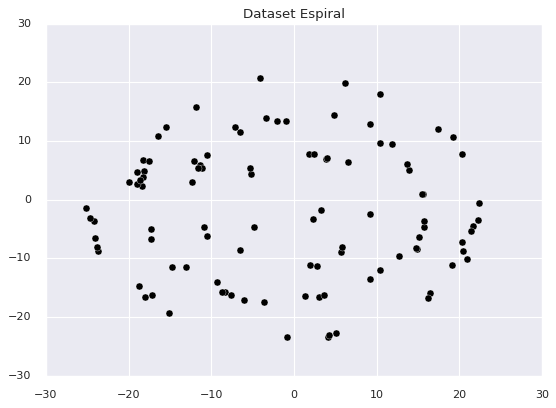

In [5]:
import seaborn as sns
sns.set()
plt.style.use('seaborn-notebook')

# dataset espiral
n = 100
u = np.sqrt(np.random.rand(n,1)) * 1440 * (2*np.pi)/360
x = -np.cos(u)*u + np.random.randn(n,1)*0.5
y = np.sin(u)*u + np.random.randn(n,1)*0.5
X = np.hstack((x,y))

plt.scatter(x, y, c = 'black',s=40)
plt.title('Dataset Espiral');

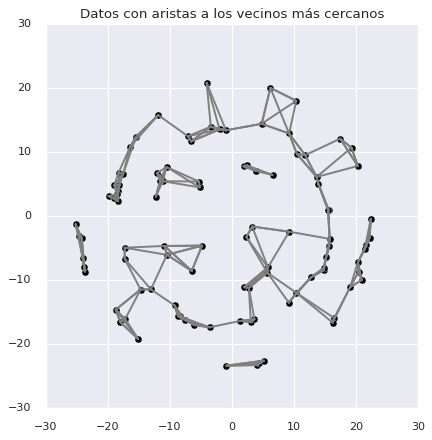

In [10]:
# recorre cada punto y grafica las lineas a los vecinos más cercanos
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40);
k = 3
neighbors = nearest_neighbors(X, k).astype('int')
for i in range(len(X)):
    knn = neighbors[i]
    for j in range(k):
        plt.plot(X[[i, knn[j]], 0], X[[i, knn[j]], 1], c='gray')

plt.title('Datos con aristas a los vecinos más cercanos');

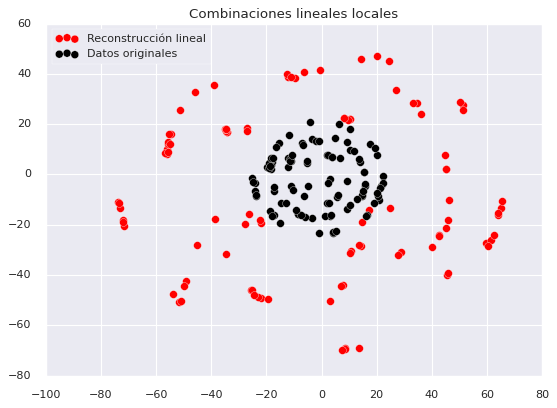

In [11]:
k=3
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
#W = barycenter_kneighbors_graph(X, n_neighbors=k)
W = kneighbors_graph(X, n_neighbors=k)

linear_combos = []
neighborhood_weights = []
for i in range(len(X)):
    weights = W.toarray()[i][neighbors[i]]
    neighborhood = X[neighbors[i]]
    weighted_neighbors = weights.reshape(-1,1)*neighborhood
    lin_x1 = np.sum(weighted_neighbors[:,0])
    lin_x2 = np.sum(weighted_neighbors[:,1])
    linear_combos.append([lin_x1, lin_x2])
    neighborhood_weights.append(weights)
linear_X = np.array(linear_combos)
plt.scatter(linear_X[:,0], linear_X[:,1], c='red', s=50, label='Reconstrucción lineal')
plt.scatter(X[:,0], X[:,1], c='black', s=50, label='Datos originales')
plt.title('Combinaciones lineales locales')
plt.legend(loc='upper left');

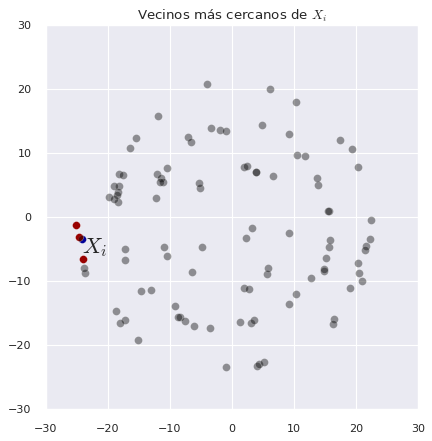

In [13]:
# neighbors for a given xi (maximum reconstruction error)
ix = np.argmax([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])
xi_neighbors = neighbors[ix] # índices de los vecinos
plt.figure(figsize=(6,6))
plt.scatter(X[ix, 0], X[ix, 1], c='blue', s=50)
plt.text(X[ix, 0], X[ix, 1]-2, s='$X_i$', size=20)
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='red', s=50)
plt.scatter(X[:,0], X[:,1], alpha=0.4, c='black', s=50)
plt.title('Vecinos más cercanos de $X_i$');

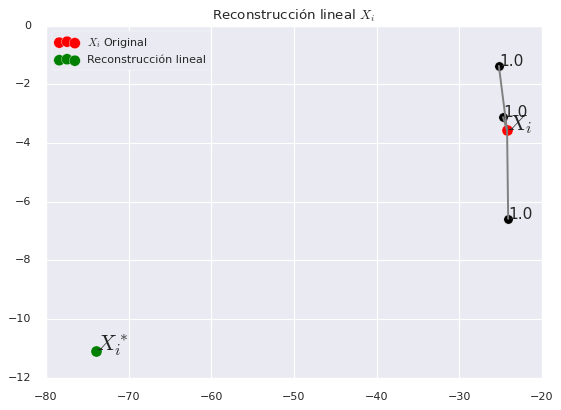

In [14]:
xi_weights = np.round(neighborhood_weights[ix],3)
plt.scatter(X[ix, 0], X[ix, 1], c='red', s=100, alpha=1, label='$X_i$ Original')
plt.text(X[ix, 0], X[ix, 1], s='$X_i$', size=20)
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='black', alpha=1, s=70)
plt.scatter(linear_X[ix,0], linear_X[ix,1], c='green', s=100, label='Reconstrucción lineal')
plt.text(linear_X[ix,0], linear_X[ix,1], s='$X_i^*$', size=20)
for i in range(len(xi_neighbors)):
    plt.text(X[xi_neighbors[i], 0], X[xi_neighbors[i], 1], s=str(xi_weights[i]), size=14)
    plt.plot(X[[ix, xi_neighbors[i]], 0], X[[ix, xi_neighbors[i]], 1], c='gray')
plt.title('Reconstrucción lineal $X_i$')
plt.legend(loc='upper left');

In [15]:
# errores de reconstrucción
np.linalg.norm(X[ix] - linear_X[ix])
np.sum([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])

50.34575511821419

3319.848016667877

## Paso 3: Mapeo a un espacio de menor dimensión

Construiremos ahora la aplicación de cada $x_i \in \mathbb{R^d}$ a su representación de menor dimensión $y_i \in \mathbb{R^m}$.

Como los pesos óptimos que hemos encontrado tienen ciertas propiedades de invariancia, usaremos estos pesos para construír la aplicación.

Definimos entonces una nueva función de costo de forma similar a la anterior, para la cual queremos minimizar el error de reconstrucción:
$$\phi(Y) = \sum_{i} ||y_i - \sum_{j} w_{ij} y_j||^2.$$

Esta vez, los pesos están fijos y encontramos las coordenadas óptimas $y_i$ con las restricciones:

- $\sum_i y_i = 0$ (centrado en el origen, grado de libertad traslacional),

- $\frac{1}{N} \sum_i y_i y_i^T = \mathbf{I}$ (covariancia 1, grado de libertad rotacional)

Reescribimos la funcioón de costo haciendo uso de nuestras restricciones:

$$
\begin{aligned}
\Phi(\mathbf{Y}) &=\sum_{i=1}^{n}\left(y_{i}-\sum_{j} w_{i j} y_{j}\right)^{2} \\
&=\sum_{i=1}^{n} y_{i}^{2}-y_{i}\left(\sum_{j} w_{i j} y_{j}\right)-\left(\sum_{j} w_{i j} y_{j}\right) y_{i}+\left(\sum_{j} w_{i j} y_{j}\right)^{2} \\
&=\mathbf{Y}^{T} \mathbf{Y}-\mathbf{Y}^{T}(\mathbf{w} \mathbf{Y})-(\mathbf{w} \mathbf{Y})^{T} \mathbf{Y}+(\mathbf{w} \mathbf{Y})^{T}(\mathbf{w} \mathbf{Y}) \\
&=(\mathbf{Y}^T-\mathbf{Y}^T\mathbf{w}^T)(\mathbf{Y}-\mathbf{w}\mathbf{Y}) \\
&=\mathbf{Y}^T(\mathbf{I}-\mathbf{w}^T)(\mathbf{I}-\mathbf{w})\mathbf{Y} \\
&=\mathbf{Y}^{T}(\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \mathbf{Y} \end{aligned}
$$

Definimos la matriz $m\times m$ $M$:
$$\begin{aligned} \mathbf{M} &= (\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \end{aligned}
$$

y luego $$\Phi(\mathbf{Y})=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}.$$

Proponemos un multiplicador de Lagrange $\mu$ para imponer la restricción $n^{-1} \mathbf{Y}^{T} \mathbf{Y} = \mathbf{I}$:
$$
\mathcal{L}(\mathbf{Y}, \mu)=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}-\mu\left(n^{-1} \mathbf{Y}^{T} \mathbf{Y}-1\right)
$$

$$
\begin{array}{c}{\frac{\partial \mathcal{L}}{\partial \mathbf{Y}}=2 \mathbf{M} \mathbf{Y}-2 \mu n^{-1} \mathbf{Y}=0} \\ {\mathbf{M Y}=\frac{\mu}{n} \mathbf{Y}}\end{array}
$$

De la última línea, $Y$ es un autovector de $M$, de modo que para minimizar $$\phi(Y) = Y^{T} M Y$$
elegimos los $m+1$ autovectores de abajo (o sea, correspondientes a los autovalores más chicos) de $M$ como las coordenadas de nuestro embedding, descartando el autovector y autovalor menores puesto que el primer autovector dera un vector unitario con todas sus componentes iguales, por cómo hemos construído $M$.

### <font color='blue'> Ejemplo:  Toy datasets</font>

Aplicamos LLE a un dataset *sintético* para manifold learning, de modod e ver cómo el algoritmo LLE puede aprender estructuras complejas no lineales.

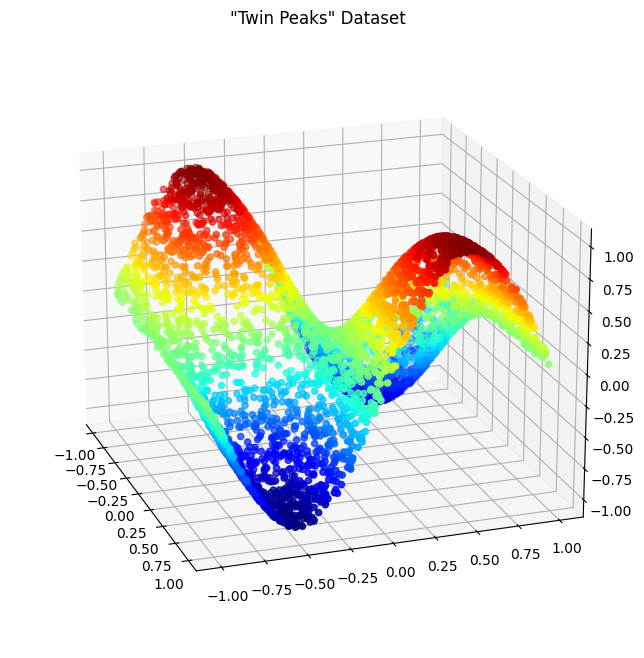

In [16]:
# Dataset twin peaks
plt.style.use('default')
n = 5000
param = 1
xy = 1 - 2 * np.random.rand(2, n)
p = np.array([xy[1, :], xy[0, :], param * np.sin(np.pi * xy[0, :]) * np.tanh(3 * xy[1, :])]).T
color = p[:, 2]
fig = plt.figure(figsize = (9, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=color, cmap=plt.cm.jet)
plt.title('"Twin Peaks" Dataset', size=12)
ax.view_init(20, -19);

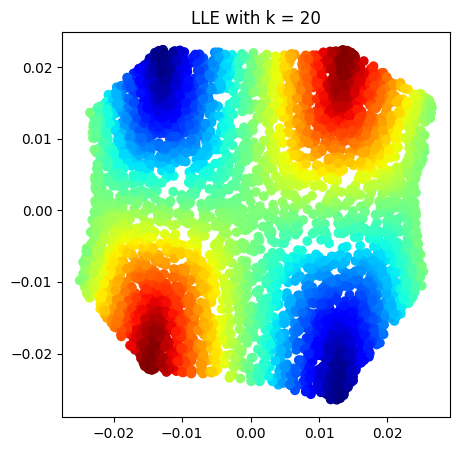

In [17]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=20)
X_reduced = lle.fit_transform(p)
fig = plt.figure(figsize = (5, 5))
plt.title('LLE with k = 20', size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.jet);

Observamos que LLE se desempeña bastante bien en este dataset altamente no lineal.

En general, el embedding 2-dimensional mantiene cerca las cosas que están cerca en $\mathbb{R^3}$ y lejos las que se encuentran lejos.

Las áreas de mayor curvatura del dataset original no están representadas tan bien y esto lleva  las áreas rojas y azules de gran densidad e irregulares.

Otro dataset sintético que puede ser desafiante para manifold learning y LLE es la siguiente construcción de agrupaciones de datos conectados.

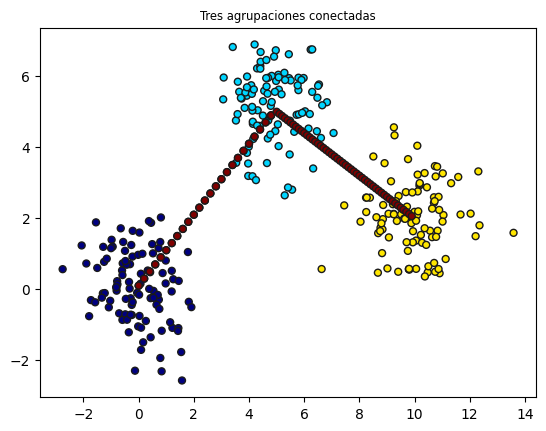

In [18]:
from sklearn.datasets import make_blobs
plt.title("Tres agrupaciones conectadas", fontsize='small')
X1, Y1 = make_blobs(n_samples=300,n_features=2, centers=[[0,0], [5,5], [10,2]])
t = np.arange(0,1,0.02)
l1 = np.array((t*5, t*5)).reshape(50,2)
l2 = np.hstack((np.array(5+5*t).reshape(-1,1),np.array(5+t*-3).reshape(-1,1)))
X = np.vstack((X1, l1, l2))
Y = np.vstack((Y1.reshape(-1,1), np.repeat(3,100).reshape(-1,1)))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y.reshape(400,),
            s=25, edgecolor='k', cmap=plt.cm.jet);

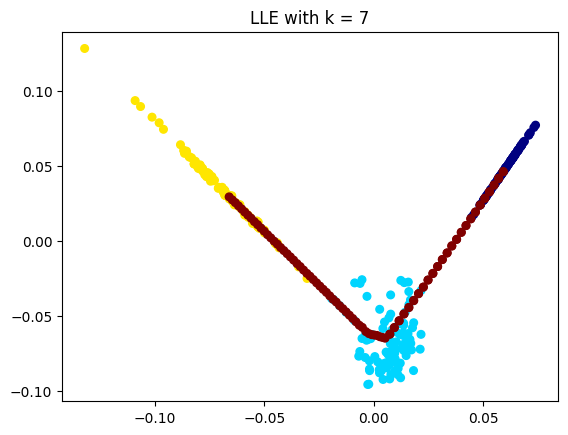

In [19]:
k = 7
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k)
X_reduced = lle.fit_transform(X)
plt.title('LLE with k = ' + str(k), size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y.reshape(400,), s=30, cmap=plt.cm.jet);

LLE es incapaz de aprender con precisión las relaciones en dos de las agrupaciones y se desempeña pobremente en este dataset.

### <font color='blue'> Ejemplo - Dígitos escritos a mano</font>

Aplicaremos LLE a un dataset de dígitos escritos a mano que sólo usa los dígitos entre 0-5.

<ipython-input-22-bbcb64d2b484>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', 6))


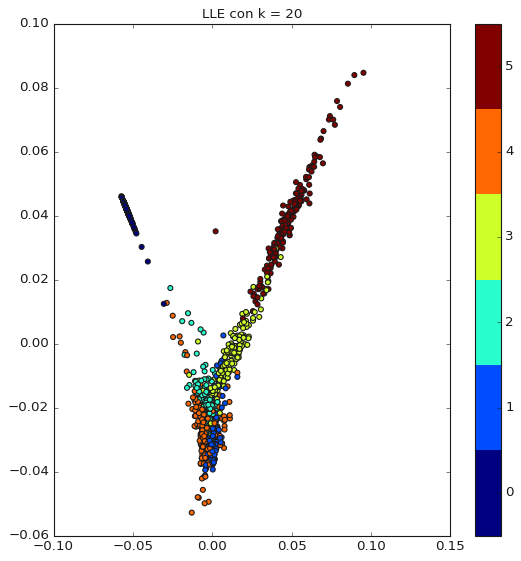

In [22]:
from sklearn import datasets
digits = datasets.load_digits(n_class=6)
data = digits.data
labels = digits.target
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=20)
X_reduced = lle.fit_transform(data)
fig = plt.figure(figsize = (8, 8))
plt.title('LLE con k = 20', size=12)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', 6))
plt.colorbar(ticks=range(6))
plt.clim(-0.5, 5.5);

LLE parece que se desempeña moderadamente bien a pesar de algunas irregularidades producidas en el embedding de dimensión baja.

### <font color='blue'> Ejemplo - Datos de imagenes</font>

En este último ejemplo aplicamos LLE a una de las fuentes más comunes de datos de grandes dimensiones: las imágenes.

Cargamos una imagen de muestra y la mostramos usando las librerías `opencv-python` y `matplotlib.image`.

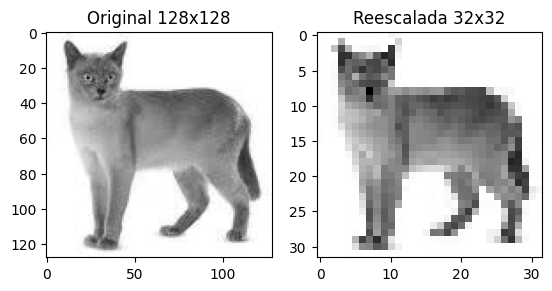

In [25]:
import cv2
import matplotlib.image as img
from skimage.color import rgb2gray
plt.style.use('default')

# leer la imagen
image = cv2.imread("/content/drive/MyDrive/MyML/TMAA/Clases/cat3.jpg")
# convertir a escala de grises y reescalar
image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
res = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.subplot(121)
plt.title('Original 128x128')
plt.imshow(image,cmap='gray')
plt.subplot(122)
plt.title('Reescalada 32x32')
plt.imshow(res,cmap='gray')
plt.show();

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Luego de reescalar nuestra imagen, obtenemos un array de dimensión 32 x 32 = 1024 con entradas numéricas de 0 a 255, representando la intensidad de cada pixel. Hay, obviamente, alguna pérdida de información en la compresión.

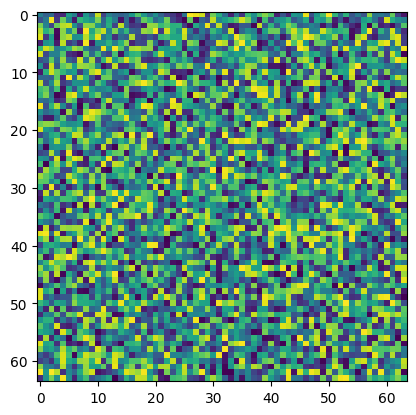

In [26]:
# crear una imagen con ruido random
test_img = 255*np.random.rand(64, 64)
plt.imshow(test_img);

Ahora creamos un conjunto de imagenes con nuestra imagen 32x32 en varias posiciones con ruido en el fondo.

In [27]:
# itera y crea imágenes trasladadas
images = []
for i in range(33):
    for j in range(33):
        tmp = np.copy(test_img)
        # mueve el gato a través del fondo
        tmp[i:i+32, j:j+32] = res
        images.append(tmp);

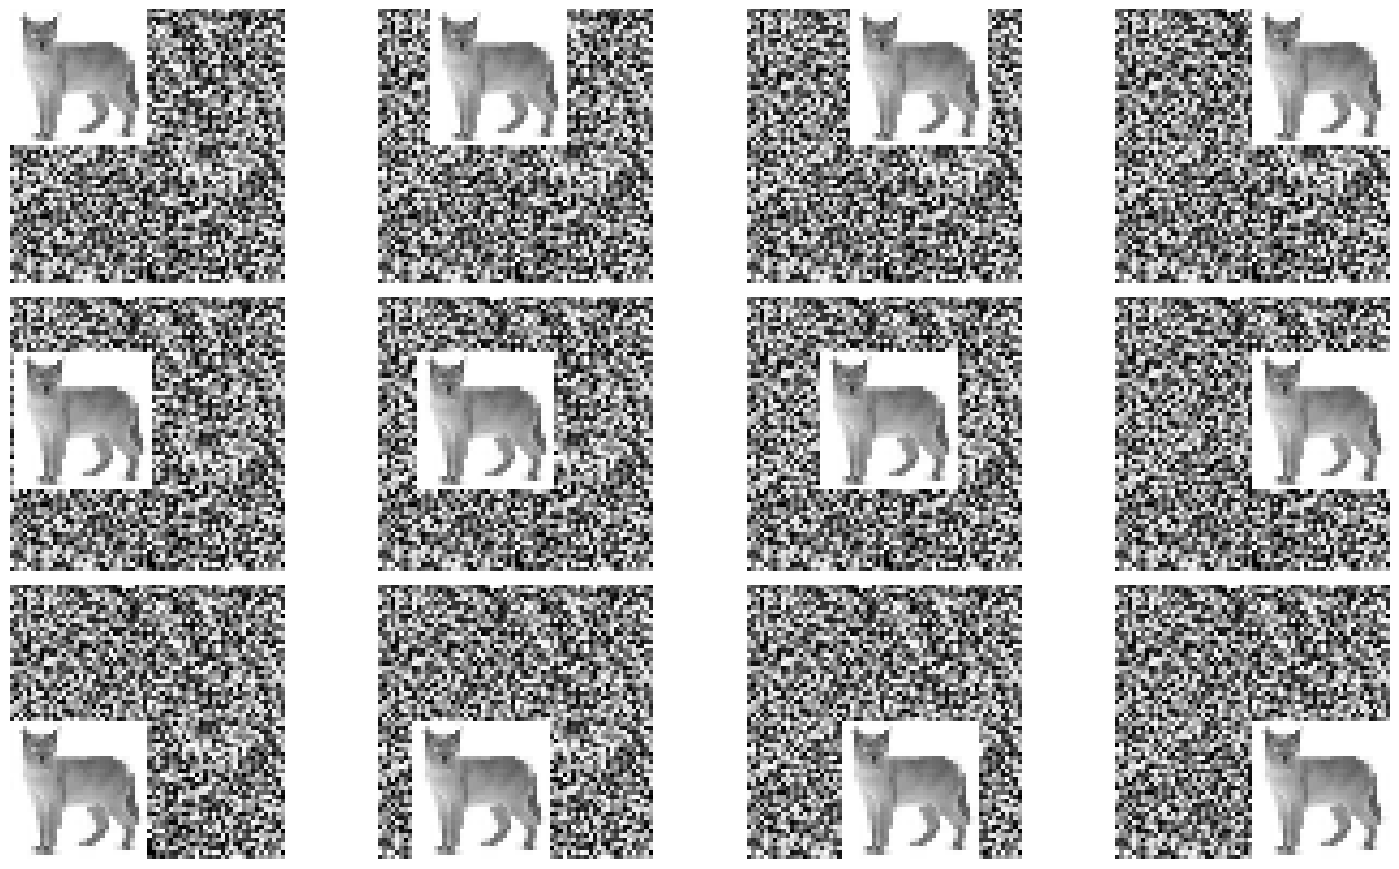

In [28]:
# grafica alguna de las imágenes generadas
F = plt.figure(figsize=(15,10))
G = plt.GridSpec(3, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01,
                 hspace=0.05, figure=F)
ax = plt.subplot(G[0])
_ = ax.imshow(images[0], cmap='gray')
selected_images = [0, 12, 24, 32, 430, 438, 446, 461, 1056, 1064, 1078, 1088]
ax.set_axis_off()
ax.set_aspect('equal')
for i in range(1, 12):
    ax = plt.subplot(G[i])
    _ = ax.imshow(images[selected_images[i]], cmap='gray')
    ax.set_axis_off()
    ax.set_aspect('equal');

In [29]:
# toma dimensiones, cantidad de muestras
np.array(images).shape
64*64

(1089, 64, 64)

4096

Ahora tenemos  n=1089 muestras de dimensión 64x64 = 4096.

Sin embargo, la dimensión intrínseca es en realidad mucho menor puesto que la única dimensionalidad son las dos dimensiones, es decir, las coordenadas (x,y) de la imagen trasladada.

Aplciamos LLE y visualizamos los resultados en 2d.

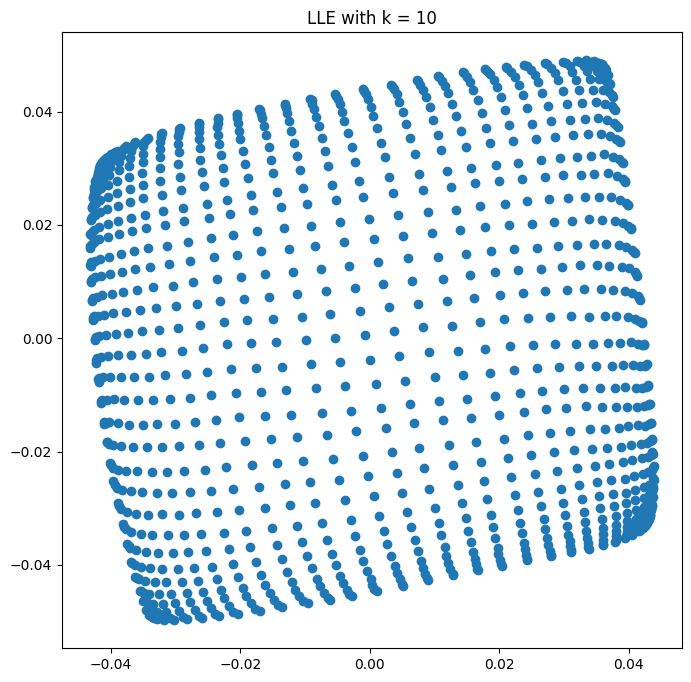

In [30]:
X = np.array(images).reshape(1089, 4096)
k = 10
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k)
X_reduced = lle.fit_transform(X)
fig = plt.figure(figsize = (8, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title('LLE with k = '+str(k), size=12);

In [31]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=1),
                                      proj[i])
            ax.add_artist(imagebox)
        for i in selected_images:
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap='gray'),
                proj[i])
            ax.add_artist(imagebox)

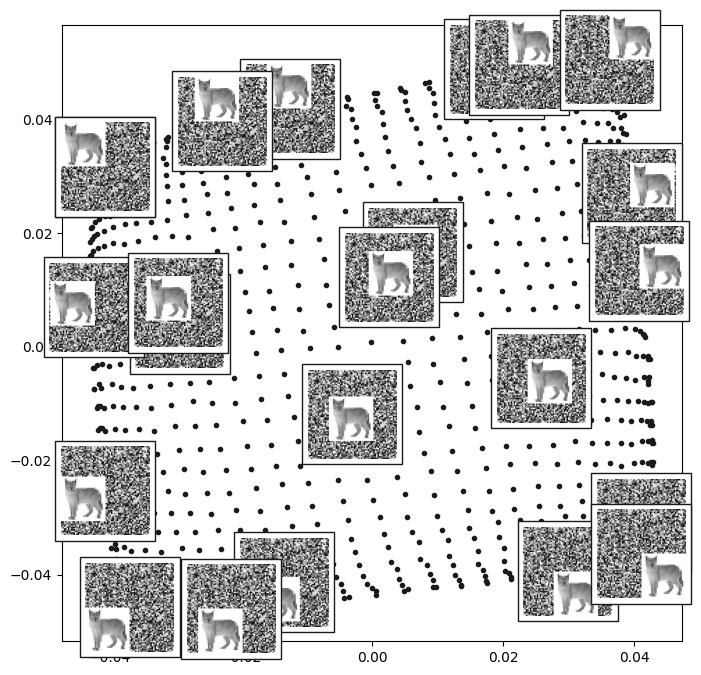

In [ ]:
plt.figure(figsize=(8,8))
plot_components(X,
                model=LocallyLinearEmbedding(n_components=2, n_neighbors=k),
                thumb_frac=0.3,
                images=images);

LLE pudo descubrir la estructura intrínseca y preservar las relaciones en dimensión mayor bastante bien cuando las imagenes están graficadas en el plano 2d, relativas a la posición del gato en la imagen como por ejemplo las esquinas y el medio.

___

### Más referencias:


-   S. T. Roweis and L. K. Saul. *Nonlinear dimensionality reduction by locally linear
embedding*. Science 290, 2323-2326 (2000). <br>
-   Think Globally, Fit Locally: Unsupervised Learning of Low Dimensional Manifolds
Lawrence K. Saul, Sam T. Roweis; 4(Jun):119-155, 2003. http://jmlr.csail.mit.edu/papers/v4/saul03a.html
-   https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/locally_linear.py